<a href="https://colab.research.google.com/github/alessiodevoto/NeuralNetworks_project/blob/main/data_analysis_and_training2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and framework

In [1]:
!python -c "import torch; print(torch.__version__)"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-geometric
!pip install wget
!pip install pickle5
!pip install pytorch-metric-learning[with-hooks]

1.9.0+cu111
Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 10.4 MB 5.4 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 3.7 MB 4.7 MB/s 
     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 407 kB 40.7 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.1-py3-none-any.whl size=513822 sha256=cd62ca1a8db66c63569f96058bc76c95587110ab201fe541ca751ebc471ec9d2
  Stored in directory: /root/.cache/pip/wheels/78/3d/42/20589db73c66b5109fb93a0c5743edfd6ab5ca820a52afacfc
Successfully built torch-geometric
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=cf14d2ae0e4a581829f08b41ea2bc25e4e988db526b4c9f50e22821da9481d87
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfu

In [2]:
cd /content/drive/MyDrive/gcn2

/content/drive/MyDrive/gcn2


# Dataset
The new PoleDataset class builds up a dataset of graphs, one for each photo in data. 
Each graph (built from a photo) represents a pylon. Each pylon belongs to a different electrical line. 
Let's just download the complete data, without filtering out any graph, and explore the properties. 

In [3]:
from PoleDataset import PoleDataset
data = PoleDataset(
    root='exploring',         # directory where to store data
    password='matching',      # password to extract 
    is_validation_set=False,  # whether this is gonna be a validation set
    num_pylons = -1,          # number of pylons we want to download. -1 = use all pylons
    edge_range=(-1, -1),  # if we want to filter out the edges, we insert the range here (-1,-1) = keep all
    keep_lines = None,        # if we only want pylons from specific lines, insert list of lines here
    normalize_edges=False,
    normalize_bboxs=False,
    force_reprocessing=True
    )


Processing...


Retrieving information about relations among assets...
Processing datasets in json format...
Parsing dataset file: exploring/raw/datasets/D110-36742.json
Parsing dataset file: exploring/raw/datasets/D550-19031.json
Parsing dataset file: exploring/raw/datasets/D340-33954.json
Parsing dataset file: exploring/raw/datasets/D260-26837.json
Parsing dataset file: exploring/raw/datasets/D550-47654.json
Parsing dataset file: exploring/raw/datasets/D110-11881.json
Parsing dataset file: exploring/raw/datasets/D340-49418.json
Parsing dataset file: exploring/raw/datasets/D260-49027.json
Building graphs(might take a while)... 
Number of elements not included (unprocessed photos): 789
Total number of processed graphs: 9444
Extracting desired number of pylons (might take a while)...
Collating...


Done!


Dataset ready!
Find raw data in exploring/raw and processed data in exploring/processed


Once the dataset is downloaded, we can explore its properties. 

``` dataset.info() ``` gives us general info about the dataset, whereas ``` dataset.per_line_info() ``` gives us info about the dataset grouping pylons by line. In both cases we can use the option ``` plots = True ``` to display plots. Plots display distribution of features both grouped or not grouped by graph:



Here is some info about this dataset:
Is validation dataset: False
Number of lines : 8
Lines : ['D340-33954', 'D110-36742', 'D110-11881', 'D260-26837', 'D550-19031', 'D550-47654', 'D340-49418', 'D260-49027']
Number of captured pylons: 1965
Number of graphs in dataset: 9444
Average number of graphs per pylon: 4.81
Average number of nodes per graph: 6.06
Average number of edges per graph: 49.33
Number of node features: 4
Number of edge features: 1
Dataset is undirected: True

PHOTOS PER PYLON
                 0
count  1965.000000
mean      4.806107
std       3.631241
min       1.000000
25%       2.000000
50%       4.000000
75%       6.000000
max      44.000000


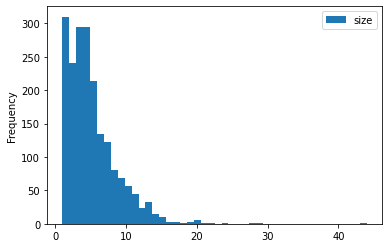


EDGES LEN:
                   0
count  465832.000000
mean        0.042581
std         0.050951
min         0.000000
25%         0.001262
50%         0.030370
75%         0.061428
max         0.711278


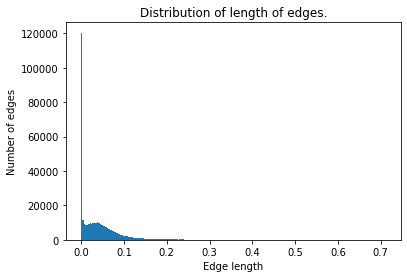


EDGE FEATURES PER GRAPH
                 0
count  9444.000000
mean      0.039993
std       0.022316
min       0.000540
25%       0.024594
50%       0.034933
75%       0.049803
max       0.222977


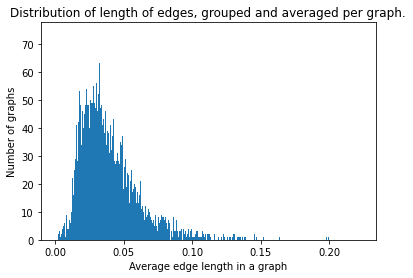


BBOX AREAS:
                  0
count  57259.000000
mean       0.014678
std        0.034681
min        0.000022
25%        0.000173
50%        0.000362
75%        0.001554
max        0.481823


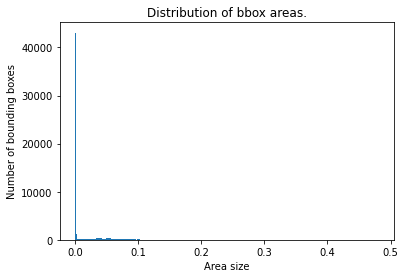


BBOX AREAS GROUPED BY GRAPH:
                 0
count  9444.000000
mean      0.017870
std       0.020749
min       0.001547
25%       0.008470
50%       0.012763
75%       0.020001
max       0.363749


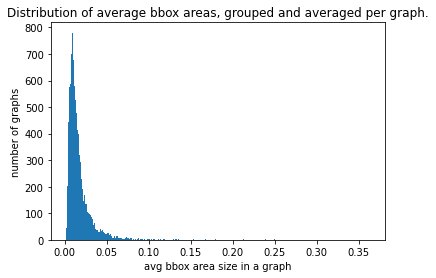

In [4]:
data.info(plots=True)

Alla luce di questo, dovremmo forse escludere dal dataset:
- gli archi fuori dal range [0.001, 4000] (vedere quanto è grande la varianza della distribuzione edge len)
- le bbox areas troppo grandi. Ache qui il 75% ha area minore di 1, e l'area massima è 48 (vedere distribuzione bbox areas)

# Info grouping by line
We can now print info grouping the pylons per line.

Abbiamo da subito deciso di non inseriere le coordinate geografiche delle foto nel dataset, essendoci stato detto che erano imprecise e quindi poco utili a distinguere i pali. Tuttavia graficando le coordinate medie (x,y) di ogni foto, cioè facendo la media su x e y delle coordinate presenti per ogni foto, risultano i seguenti grafici:
N:B: foto dello stesso palo hanno lo stesso colore



Here is some info about each line contained in the dataset


INFO FOR LINE: D110-36742
num_graphs: 471 
num_pylons: 108 
avg_photos_per_pylon: 4.36


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


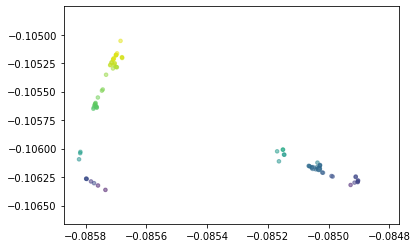



INFO FOR LINE: D550-19031
num_graphs: 366 
num_pylons: 63 
avg_photos_per_pylon: 5.81


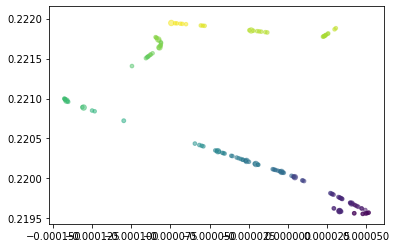



INFO FOR LINE: D340-33954
num_graphs: 2526 
num_pylons: 440 
avg_photos_per_pylon: 5.74


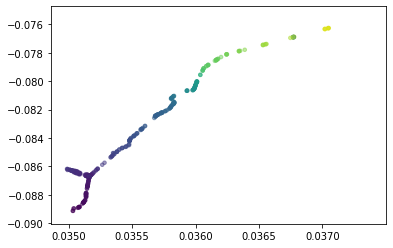



INFO FOR LINE: D260-26837
num_graphs: 1488 
num_pylons: 302 
avg_photos_per_pylon: 4.93


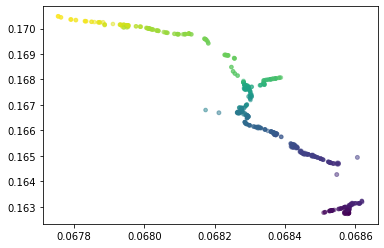



INFO FOR LINE: D550-47654
num_graphs: 199 
num_pylons: 48 
avg_photos_per_pylon: 4.15


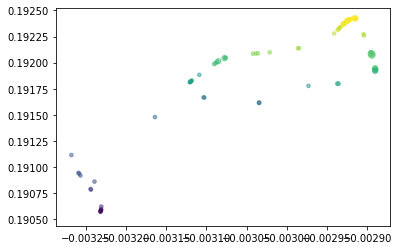



INFO FOR LINE: D110-11881
num_graphs: 2725 
num_pylons: 619 
avg_photos_per_pylon: 4.40


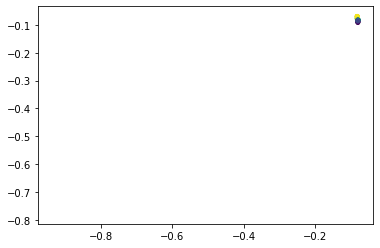



INFO FOR LINE: D340-49418
num_graphs: 1090 
num_pylons: 260 
avg_photos_per_pylon: 4.19


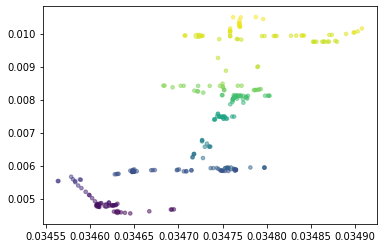



INFO FOR LINE: D260-49027
num_graphs: 579 
num_pylons: 125 
avg_photos_per_pylon: 4.63


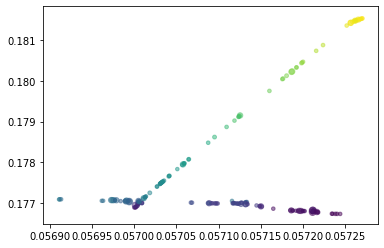

In [ ]:
data.per_line_info(plots=True)

Quindi, eccezion fatta per un paio di linee, in cui sì, tutti i pali hanno le stesse coordinate, potremmo includere anche questa informazione.  

Let's now check the format of a single element of the dataset.
Every graph is stored in the dataset as a 'Data' object, with the following attributes:
- x : features matrix [num nodes, num nodes features]
- edge_idx : graph connectivity [2, num edges * 2]
- edge_attr : edge attributes [num edges, num edge features]
- photo_id : [String] the id of the photo this graph comes from
- pylon_id : [String] the id of the pylon this graph represents
- line_id : [String] the line this pylon belongs to
- y: target: [int] a numerical id representing the pylon 

In [7]:
import utils
g0, idx = data.get_by_photo_id('F_2020_06_23@15.59.43(128)_Converted_CROP_1_263.jpg')

print('This is a single graph object')
print(g0)

This is a single graph object
Data(x=[6, 4], edge_index=[2, 42], edge_attr=[42, 1], y=[1], photo_id='F_2020_06_23@15.59.43(128)_Converted_CROP_1_263.jpg', pylon_id='504831_4353939_50', line_id='D110-36742')


As we can see, this graph posseses 6 nodes, each node is described by 4 features.
Let's check the content of the feature matrix x:

In [8]:
print('\nFEATURE MATRIX:')
print(g0.x)


FEATURE MATRIX:
tensor([[   17.0000,     0.7976,     0.9000,     0.0480],
        [    1.0000,     1.0000,     0.1000,     0.0206],
        [    5.0000,     0.5441,     0.7000,     0.0012],
        [    5.0000,     0.5418,     0.7000,     0.0012],
        [    5.0000,     0.4841,     0.7000,     0.0012],
        [   11.0000,     0.8699,     0.9000,     0.0076]])


The features for each vector are:
- category id
- manual weight assigned by experts
- score on previous model
- bbox area

Let's also check the content of the other attributes in the graph.

In [9]:
print('\nGRAPH CONNECTIVITY:')
print(g0.edge_index)
print('\nEDGE FEATURES:')
print(g0.edge_attr)
print('\nY')
print(g0.y)
print('\nPYLON_ID')
print(g0.pylon_id)
print('\nLINE_ID')
print(g0.line_id)
print('\nPHOTO_ID')
print(g0.photo_id)


GRAPH CONNECTIVITY:
tensor([[0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 1, 1, 1, 2, 1, 3, 1, 4, 1, 5, 2, 2,
         2, 3, 2, 4, 2, 5, 3, 3, 3, 4, 3, 5, 4, 4, 4, 5, 5, 5],
        [0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 1, 2, 1, 3, 1, 4, 1, 5, 1, 2, 2,
         3, 2, 4, 2, 5, 2, 3, 3, 4, 3, 5, 3, 4, 4, 5, 4, 5, 5]])

EDGE FEATURES:
tensor([[0.0000],
        [0.0000],
        [0.1609],
        [0.1609],
        [0.0296],
        [0.0296],
        [0.0238],
        [0.0238],
        [0.0451],
        [0.0451],
        [0.0088],
        [0.0088],
        [0.0000],
        [0.0000],
        [0.1262],
        [0.1262],
        [0.1527],
        [0.1527],
        [0.0715],
        [0.0715],
        [0.0436],
        [0.0436],
        [0.0000],
        [0.0000],
        [0.0156],
        [0.0156],
        [0.0041],
        [0.0041],
        [0.0113],
        [0.0113],
        [0.0000],
        [0.0000],
        [0.0465],
        [0.0465],
        [0.0166],
        [0.0166],
        [0.0000],
      

We can now display the graph:

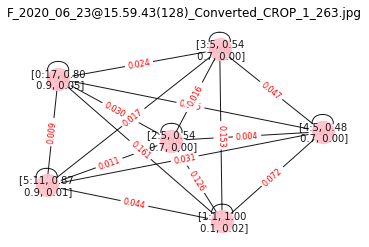

In [10]:
utils.display_graph(g0)

# Model

Let's start by loading the data into train and validation set. Notice: we must use the is_validation_set option in the dataset and not slice the previously dowloaded one, else we end up taking random graphs from several pylons. What we want is instead to build dataset based on pylons!

Because we know from before that we have 1965 pylons, we use 1900 of them for training and 65 for validation.


Dataset ready!
Find raw data in train_data/raw and processed data in train_data/processed

Here is some info about this dataset:
Is validation dataset: False
Number of lines : 8
Lines : ['D340-33954', 'D110-36742', 'D110-11881', 'D260-26837', 'D550-19031', 'D550-47654', 'D340-49418', 'D260-49027']
Number of captured pylons: 1900
Number of graphs in dataset: 9156
Average number of graphs per pylon: 4.82
Average number of nodes per graph: 6.06
Average number of edges per graph: 24.37
Number of node features: 4
Number of edge features: 1
Dataset is undirected: True

PHOTOS PER PYLON
                 0
count  1900.000000
mean      4.818947
std       3.659099
min       1.000000
25%       2.000000
50%       4.000000
75%       6.000000
max      44.000000


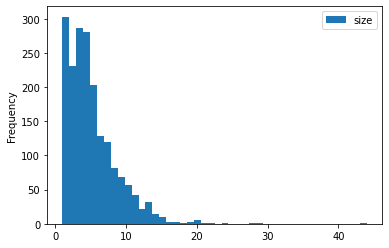


EDGES LEN:
                   0
count  223162.000000
mean        0.490966
std         0.279942
min         0.000000
25%         0.251765
50%         0.493627
75%         0.724348
max         1.000000


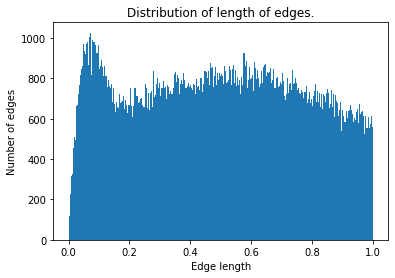


EDGE FEATURES PER GRAPH
                 0
count  8733.000000
mean      0.518800
std       0.147154
min       0.000474
25%       0.432654
50%       0.510203
75%       0.599779
max       0.995263


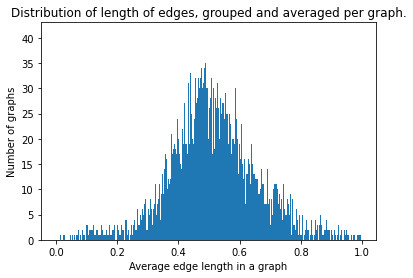


BBOX AREAS:
                  0
count  55458.000000
mean       0.500853
std        0.362967
min        0.000000
25%        0.171618
50%        0.361622
75%        1.000000
max        1.000000


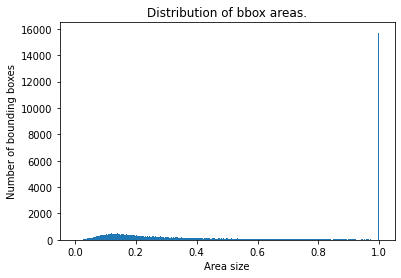


BBOX AREAS GROUPED BY GRAPH:
                 0
count  9156.000000
mean      0.537078
std       0.222468
min       0.130214
25%       0.368580
50%       0.487184
75%       0.667188
max       1.000000


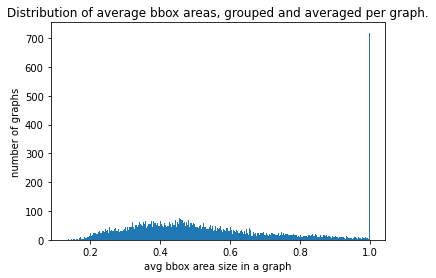

Dataset ready!
Find raw data in val_data/raw and processed data in val_data/processed

Here is some info about this dataset:
Is validation dataset: True
Number of lines : 7
Lines : ['D340-33954', 'D110-36742', 'D110-11881', 'D260-26837', 'D550-19031', 'D550-47654', 'D340-49418']
Number of captured pylons: 65
Number of graphs in dataset: 288
Average number of graphs per pylon: 4.43
Average number of nodes per graph: 6.25
Average number of edges per graph: 26.60
Number of node features: 4
Number of edge features: 1
Dataset is undirected: True

PHOTOS PER PYLON
               0
count  65.000000
mean    4.430769
std     2.686594
min     1.000000
25%     3.000000
50%     4.000000
75%     5.000000
max    13.000000


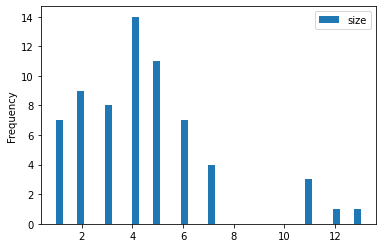


EDGES LEN:
                 0
count  7662.000000
mean      0.480890
std       0.285654
min       0.000755
25%       0.226263
50%       0.490257
75%       0.722089
max       0.999935


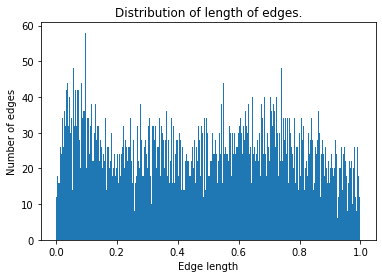


EDGE FEATURES PER GRAPH
                0
count  261.000000
mean     0.500177
std      0.138437
min      0.074103
25%      0.433666
50%      0.494908
75%      0.566688
max      0.992251


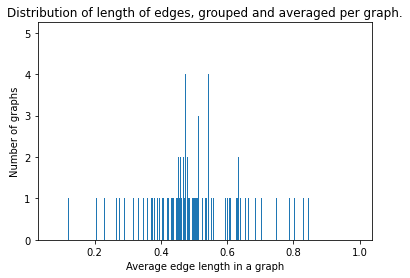


BBOX AREAS:
                 0
count  1801.000000
mean      0.470665
std       0.350053
min       0.054687
25%       0.166466
50%       0.329352
75%       1.000000
max       1.000000


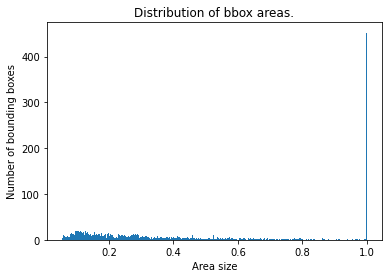


BBOX AREAS GROUPED BY GRAPH:
                0
count  288.000000
mean     0.525448
std      0.210755
min      0.162577
25%      0.382106
50%      0.493169
75%      0.626151
max      1.000000


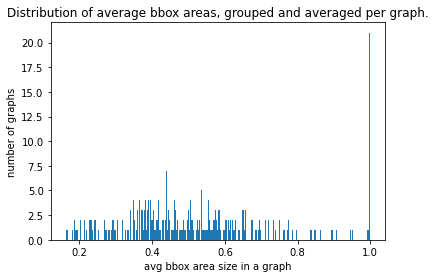

In [6]:
%matplotlib inline
from PoleDataset import PoleDataset
import torch
import numpy as np
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import utils, config
from pytorch_metric_learning import losses, miners, reducers, regularizers, samplers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator



# DATA LOADING

# Training and validation data
train_data = PoleDataset(root='train_data',
                         password='matching',
                         is_validation_set=False,
                         num_pylons=1900,
                         edge_range=(0.0001, 0.06),   # We only keep edges in this range
                         bbox_threshold= 0.001,
                         force_reprocessing=False)
train_data.info(plots=True)

# Validation data
val_data = PoleDataset(root='val_data',
                       password='matching',
                       is_validation_set=True,
                       num_pylons=65,
                       edge_range=(0.0001, 0.06),
                       bbox_threshold=0.001,
                       force_reprocessing=False)
val_data.info(plots=True)

We now use pytorch metric learning library to mine triplets to be fed to the net. 
Note: from now on we use target or class to refere to the pylon id, because we can see the photos capturing the same pylon as beloging to the same class. 

We are going to define:
- A sampler, that creates batches of size config.batch_size (64) according to specific rules 
- A dataloader, which is nothing but a plain Pytorch dataloader
- A miner, that selects on wich triplets the loss function should be used, once the embeddings are already computed
- A loss function, that works with triplets
- A reducer, that computes a reduction of the loss function to a scalar (e.g. computing the mean)

In [ ]:
import single_network


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Samplers (data miners)
# This sampler extracts m elements of each class (i.e. capturing the same pylon) 
batch_size = config.batch_size
train_labels = torch.cat([elem.y for elem in train_data])
train_sampler = samplers.MPerClassSampler(labels=train_labels, m=4, batch_size=config.batch_size)
val_labels = torch.cat([elem.y for elem in val_data])
val_sampler = samplers.MPerClassSampler(labels=val_labels, m=4, batch_size=config.batch_size)

# Dataloaders
train_loader = DataLoader(train_data, batch_size=config.batch_size, sampler=train_sampler)
val_loader = DataLoader(val_data, batch_size=config.batch_size, sampler=val_sampler)

"""LOSS SETTINGS"""
miner = miners.BatchEasyHardMiner()
reducer = reducers.MeanReducer()
# reducer = reducers.AvgNonZeroReducer()
criterion = losses.TripletMarginLoss(reducer=reducer)

"""GENERAL TRAINING SETTINGS and MODEL"""
learning_rate = 0.0001
num_epochs = 80

model = single_network.SingleGraphEmbeddingNet(config.get_network_settings())
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

Built model with following settings:
{'num_categories': 49, 'categorical_embedding_dim': 8, 'linear_embedding_layers': [52], 'convolutional_layers': [64, 64], 'concat_convolutions': True, 'aggregator_out_dim': 72, 'pooling': None, 'kernel_size': 3, 'stride': 2, 'padding': 0}
SingleGraphEmbeddingNet(
  (embedding_net): NodeFeaturesEmbedding(
    (categorical_embedding): Embedding(49, 8)
    (linear_embedding): Sequential(
      (0): Linear(in_features=11, out_features=52, bias=True)
      (1): ReLU()
    )
  )
  (convolutions): MessageNet(
    (conv1): GCNConv(52, 64)
    (conv2): GCNConv(64, 64)
  )
  (aggregator): GraphAggregator(
    (aggregator): Linear(in_features=128, out_features=72, bias=True)
  )
)


We can now define the training and validation routine. 

In [ ]:
# Training routine for one epoch

def train_epoch(epoch, train_loader):
    # Training
    model.train()
    train_losses = []
    for i, batch in enumerate(train_loader):
        x, edge_index, edge_attr, y, batch_map = batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(
            device), batch.y.to(device), batch.batch.to(device)
        # Get the embedding for each graph in batch:    
        embeddings = model(x, edge_index, batch_map) 
        # Select hardest embeddings:   
        mined_embeddings = miner(embeddings, y) if miner is not None else None
        # Compute the loss:
        train_loss = criterion(embeddings, y, mined_embeddings)  
        train_losses.append(train_loss)
        # Derive, update and clear gradients:
        train_loss.backward()  
        optimizer.step() 
        optimizer.zero_grad()  
    print(
        f'\n\nEpoch: {epoch:03d}, \n'
        f'Train loss: {torch.stack(train_losses).mean()}'
    )


In [ ]:
# Little aux function for displaying what we are doing
import os
def get_abs_path(datas):
  ids =  [os.path.join(data.line_id, 'images', data.pylon_id, data.photo_id) for data in datas]
  return ids

In [ ]:
# Validation routine for one epoch
import pickle
def test_epoch(epoch, val_loader, save_distances=False):
    
    model.eval()
    
    # Variables to store epoch info
    val_losses = []
    epoch_accuracies = []
    
    epoch_auc = []
    epoch_distances = []
    
    all_y = []
    all_emb = []
    
    all_anc_names = []
    all_pos_names = []
    all_neg_names = []
    pos_dists = []
    neg_dists = []

    # Accuracy calculator from pytorch metric learnign library, to be used later 
    calc = AccuracyCalculator(include=(['mean_average_precision']),
                              exclude=(),
                              avg_of_avgs=False,
                              k=30,
                              label_comparison_fn=None)
    
    # Iterate in batches over dataset
    for i, batch in enumerate(val_loader):  
        x, edge_index, edge_attr, y, batch_map = batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(
            device), batch.y.to(device), batch.batch.to(device)
        embeddings = model(x, edge_index, batch_map)
        
       
        # Same as before
        mined_embeddings = miner(embeddings, y) if miner is not None else embeddings
        val_loss = criterion(embeddings, y, mined_embeddings) 
        val_losses.append(val_loss)

        # We store embeddings and labels for later evaluation
        all_emb.append(embeddings)
        all_y.append(y)

        with torch.no_grad():
            # Indices of embeddings selected by miner
            anc = embeddings[mined_embeddings[0]]
            anc = F.normalize(anc)
            pos = embeddings[mined_embeddings[1]]
            pos = F.normalize(pos)
            neg = embeddings[mined_embeddings[3]]
            neg = F.normalize(neg)
            
            # Compute the distances between anchors, positives and negatives
            pos_dist = F.pairwise_distance(anc, pos, keepdim=True).to(device)
            neg_dist = F.pairwise_distance(anc, neg, keepdim=True).to(device)

            if save_distances:
                anc_names = get_abs_path(batch[mined_embeddings[0]])
                all_anc_names.extend(anc_names)
                pos_names = get_abs_path(batch[mined_embeddings[1]])
                all_pos_names.extend(pos_names)
                neg_names = get_abs_path(batch[mined_embeddings[3]])
                all_neg_names.extend(neg_names)
                pos_dists.extend(pos_dist.squeeze(1).tolist())
                neg_dists.extend(neg_dist.squeeze(1).tolist())

            # Basic accuracy evaluation
            # Ha senso fare questo calcolo? Forse no
            acc = torch.where(pos_dist < neg_dist, 1, 0).float().to(device)
            epoch_accuracies.append(acc)

            # ROC based evaluation
            # Build vector labels for distances
            one_label = torch.ones_like(pos_dist).to(device)
            zero_label = torch.zeros_like(neg_dist).to(device)
            # Add labels to anc-pos and anc-neg ditance   
            labelled_pos_dist = torch.cat((pos_dist, zero_label), 1)
            labelled_neg_dist = torch.cat((neg_dist, one_label), 1)
            distances = torch.cat((labelled_pos_dist, labelled_neg_dist), 0)
            epoch_distances.append(distances)
            # Just to make it clear the vector distances is now of the form:
            # [distance, label] where
            # label is 1 if distance is anchor positive, 0 if distance is anchor negative

    # STORE RESULTS FOR LATTER DISPLAYING
    correct = [1 if (pos_dists[idx]<neg_dists[idx]) else 0 for idx in range(len(pos_dists)) ]
    with open(f'{str(epoch)}_results.pkl', 'wb') as f:
      lines = []
      for x in zip(all_anc_names, all_pos_names, all_neg_names, pos_dists, neg_dists, correct):
        #lines.append(f'anchor: {x[0]}, pos: {x[1]}, neg:{x[2]}, pos_dist:{x[3]:.4f}, neg_dist:{x[4]:.4f}\n')
        lines.append(x)
      #f.writelines(lines)
      pickle.dump(lines, f)
    

    # COMPUTE ACCURACIES WITH LIBRARY FEATURE:

    total_emb = torch.cat(all_emb).cpu().detach().numpy()
    total_y = torch.cat(all_y).cpu().detach().numpy()
    # These two vector store all the embeddings together with their label

    accs = calc.get_accuracy(
        query=total_emb,
        reference=total_emb,
        query_labels=total_y,
        reference_labels=total_y,
        embeddings_come_from_same_source=True)

    print(accs)

    # MANUALLY COMPUTE ACCURACIES: 

    total_distances = torch.cat(epoch_distances)
    # Again, just to make it clear the vector distances is now of the form:
    # [distance, label] where
    # label is 1 if distance is anchor positive, 0 if distance is anchor negative

    auc, fpr, tpr, thresholds = utils.auc(total_distances[:, 0], total_distances[:, 1], epoch)
    total_acc = torch.cat(epoch_accuracies)

    print(
        f'Val loss: {torch.stack(val_losses).mean()},\n'
        f'METRICS -> Accuracy: {total_acc.mean()}, AUC: {auc}\n'
        f'THRESHOLD -> Avg anchor-pos distance: {total_distances[:, 0].mean()}, avg anchor-neg distance: {total_distances[:, 1].mean()}'
    )

    plot_roc(fpr, tpr, auc, epoch)



Let's train the net 



Epoch: 000, 
Train loss: 0.013711453415453434


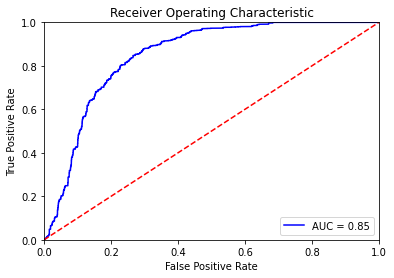

Val loss: 0.008109972812235355,
METRICS -> Accuracy: 1.0, AUC: 0.8486558676970442
THRESHOLD -> pos mean dist 0.13701856136322021, neg mean dist 0.5
{'mean_average_precision': 0.9907070262483995}


Epoch: 001, 
Train loss: 0.005648292601108551


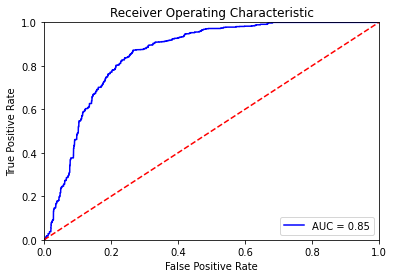

Val loss: 0.0064986939541995525,
METRICS -> Accuracy: 1.0, AUC: 0.8543916724105378
THRESHOLD -> pos mean dist 0.1935996264219284, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 002, 
Train loss: 0.004700150806456804


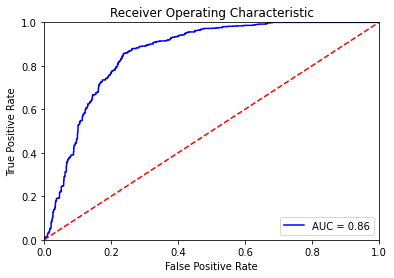

Val loss: 0.0057486360892653465,
METRICS -> Accuracy: 1.0, AUC: 0.8584362305837036
THRESHOLD -> pos mean dist 0.2135145366191864, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 003, 
Train loss: 0.004151602741330862


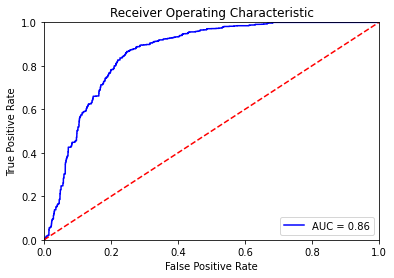

Val loss: 0.005513656418770552,
METRICS -> Accuracy: 1.0, AUC: 0.8595178047804362
THRESHOLD -> pos mean dist 0.23278702795505524, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 004, 
Train loss: 0.00400162860751152


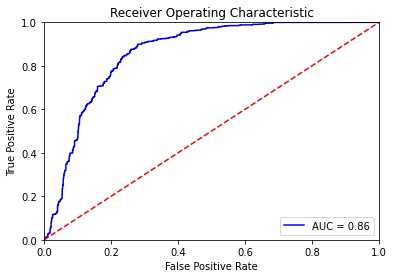

Val loss: 0.005181091837584972,
METRICS -> Accuracy: 1.0, AUC: 0.8593957658380099
THRESHOLD -> pos mean dist 0.24963942170143127, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 005, 
Train loss: 0.0036302919033914804


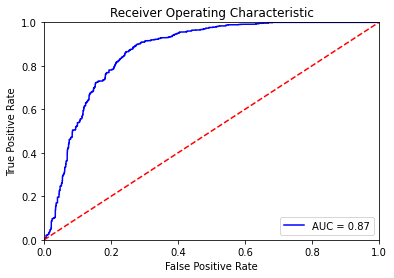

Val loss: 0.004701578989624977,
METRICS -> Accuracy: 1.0, AUC: 0.8668041408894253
THRESHOLD -> pos mean dist 0.25511664152145386, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 006, 
Train loss: 0.003544736420735717


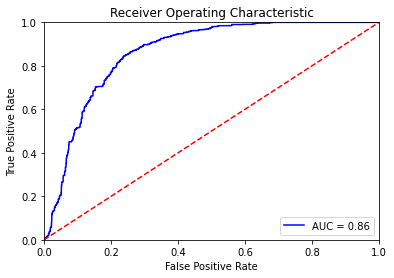

Val loss: 0.0046903220936656,
METRICS -> Accuracy: 1.0, AUC: 0.8625747018815547
THRESHOLD -> pos mean dist 0.26263627409935, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 007, 
Train loss: 0.003389943391084671


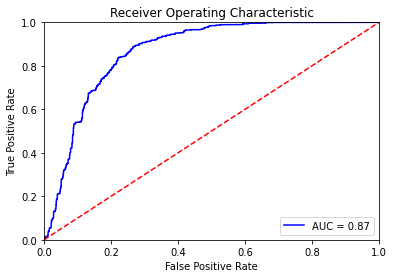

Val loss: 0.0042577628046274185,
METRICS -> Accuracy: 1.0, AUC: 0.8672933095072497
THRESHOLD -> pos mean dist 0.2723921239376068, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 008, 
Train loss: 0.003185913898050785


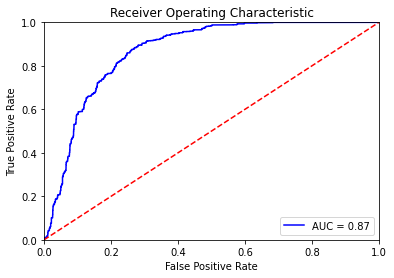

Val loss: 0.0040701646357774734,
METRICS -> Accuracy: 1.0, AUC: 0.8675427997054288
THRESHOLD -> pos mean dist 0.2739154100418091, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 009, 
Train loss: 0.0030889303889125586


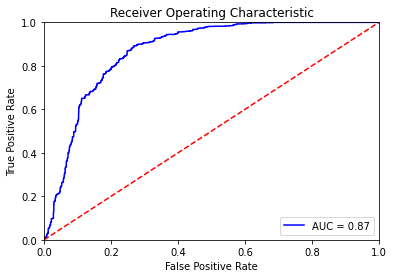

Val loss: 0.004060676787048578,
METRICS -> Accuracy: 1.0, AUC: 0.8693467171778899
THRESHOLD -> pos mean dist 0.28711819648742676, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 010, 
Train loss: 0.002980532357469201


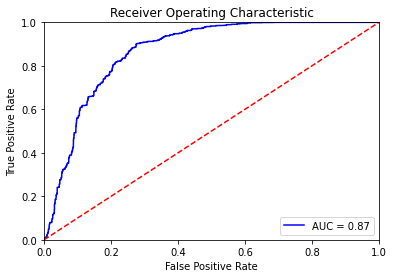

Val loss: 0.00405415054410696,
METRICS -> Accuracy: 1.0, AUC: 0.867459029451044
THRESHOLD -> pos mean dist 0.29263558983802795, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 011, 
Train loss: 0.0028216757345944643


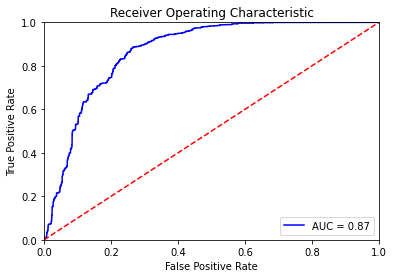

Val loss: 0.0038022170774638653,
METRICS -> Accuracy: 1.0, AUC: 0.8677412423383933
THRESHOLD -> pos mean dist 0.29471921920776367, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 012, 
Train loss: 0.0027704599779099226


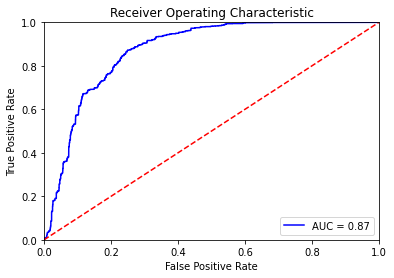

Val loss: 0.003856666386127472,
METRICS -> Accuracy: 1.0, AUC: 0.8728940029775597
THRESHOLD -> pos mean dist 0.3031209409236908, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 013, 
Train loss: 0.002719622105360031


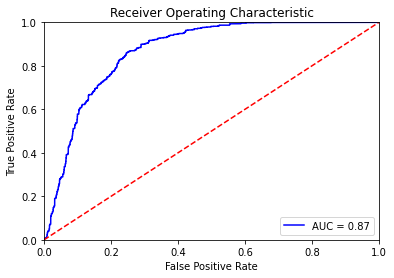

Val loss: 0.0038908759597688913,
METRICS -> Accuracy: 1.0, AUC: 0.8685821508337214
THRESHOLD -> pos mean dist 0.31148359179496765, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 014, 
Train loss: 0.002716718940064311


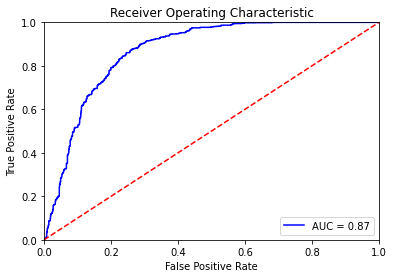

Val loss: 0.004219835624098778,
METRICS -> Accuracy: 1.0, AUC: 0.8690005058881166
THRESHOLD -> pos mean dist 0.3000742197036743, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 015, 
Train loss: 0.0026255734264850616


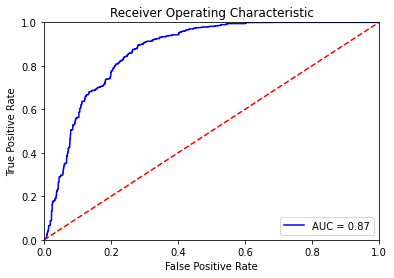

Val loss: 0.0037552574649453163,
METRICS -> Accuracy: 1.0, AUC: 0.8705128225659291
THRESHOLD -> pos mean dist 0.3111816644668579, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 016, 
Train loss: 0.002595641417428851


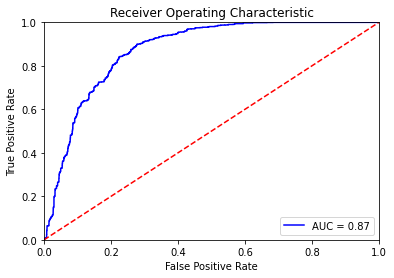

Val loss: 0.0036926856264472008,
METRICS -> Accuracy: 1.0, AUC: 0.8737945005037655
THRESHOLD -> pos mean dist 0.3154750168323517, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 017, 
Train loss: 0.0024626897647976875


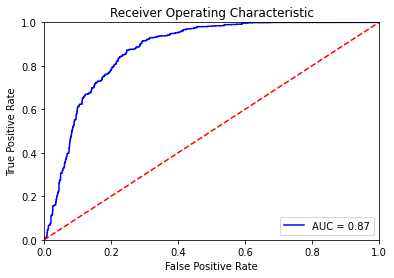

Val loss: 0.003531906520947814,
METRICS -> Accuracy: 0.9999800324440002, AUC: 0.8739850632444058
THRESHOLD -> pos mean dist 0.32866838574409485, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 018, 
Train loss: 0.0025679320096969604


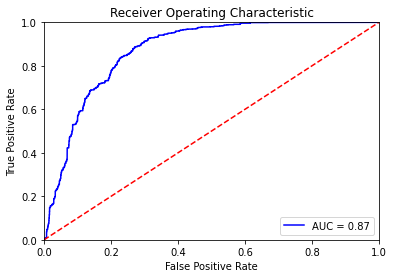

Val loss: 0.0035057328641414642,
METRICS -> Accuracy: 1.0, AUC: 0.8725691571595005
THRESHOLD -> pos mean dist 0.320950984954834, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 019, 
Train loss: 0.002515359316021204


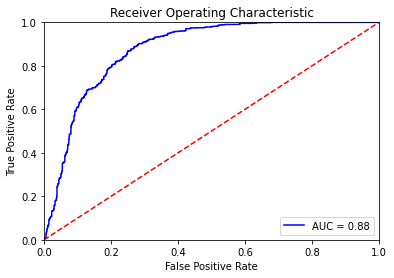

Val loss: 0.0036603810731321573,
METRICS -> Accuracy: 1.0, AUC: 0.8758870095953112
THRESHOLD -> pos mean dist 0.32769864797592163, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 020, 
Train loss: 0.00248203263618052


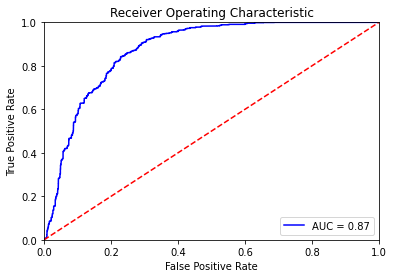

Val loss: 0.003386314958333969,
METRICS -> Accuracy: 1.0, AUC: 0.874329150725159
THRESHOLD -> pos mean dist 0.33279141783714294, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 021, 
Train loss: 0.002355347154662013


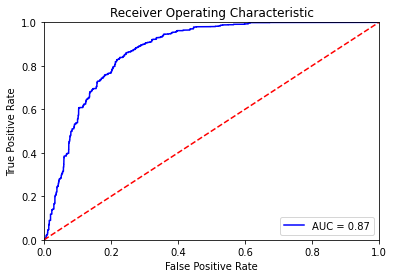

Val loss: 0.0035360301844775677,
METRICS -> Accuracy: 1.0, AUC: 0.8723900670601757
THRESHOLD -> pos mean dist 0.33287081122398376, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 022, 
Train loss: 0.00246048322878778


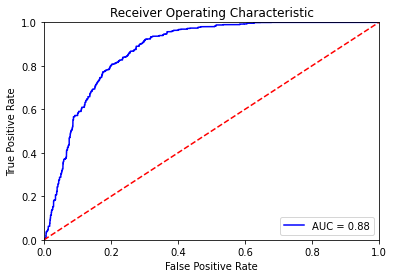

Val loss: 0.003574484260752797,
METRICS -> Accuracy: 1.0, AUC: 0.875104003251431
THRESHOLD -> pos mean dist 0.3332047164440155, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 023, 
Train loss: 0.0023304803762584925


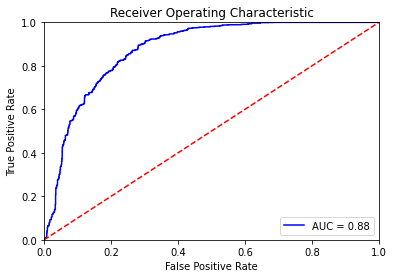

Val loss: 0.00322232604958117,
METRICS -> Accuracy: 1.0, AUC: 0.8759062628154005
THRESHOLD -> pos mean dist 0.34683531522750854, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 024, 
Train loss: 0.002303679706528783


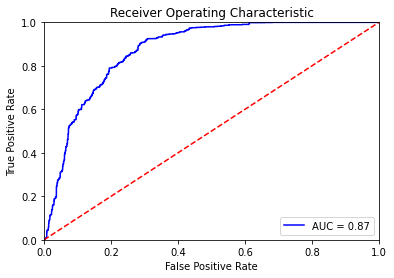

Val loss: 0.003469495801255107,
METRICS -> Accuracy: 1.0, AUC: 0.8726138406523603
THRESHOLD -> pos mean dist 0.3426816463470459, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 025, 
Train loss: 0.0023024599067866802


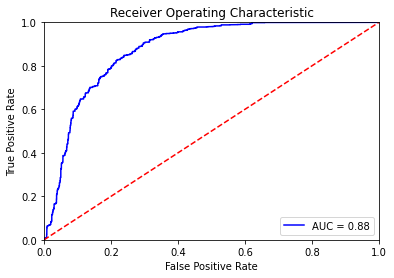

Val loss: 0.003146484727039933,
METRICS -> Accuracy: 1.0, AUC: 0.8758531726431267
THRESHOLD -> pos mean dist 0.3500131666660309, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 026, 
Train loss: 0.002234827494248748


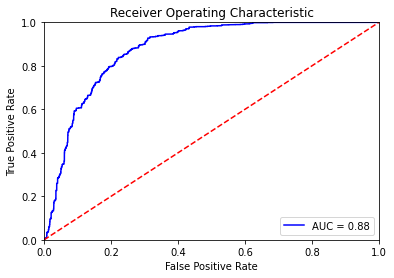

Val loss: 0.0033714952878654003,
METRICS -> Accuracy: 1.0, AUC: 0.8769345383064194
THRESHOLD -> pos mean dist 0.3575911819934845, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 027, 
Train loss: 0.002277456456795335


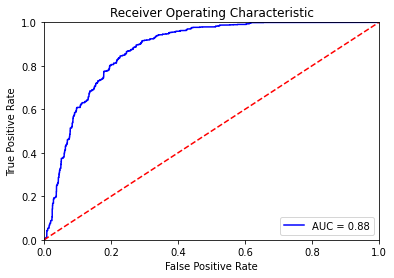

Val loss: 0.003367143915966153,
METRICS -> Accuracy: 1.0, AUC: 0.8772965329959524
THRESHOLD -> pos mean dist 0.34517788887023926, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 028, 
Train loss: 0.0022355264518409967


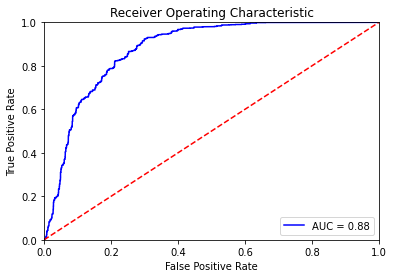

Val loss: 0.0033496369142085314,
METRICS -> Accuracy: 1.0, AUC: 0.8758875476896365
THRESHOLD -> pos mean dist 0.35298195481300354, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 029, 
Train loss: 0.0022000474855303764


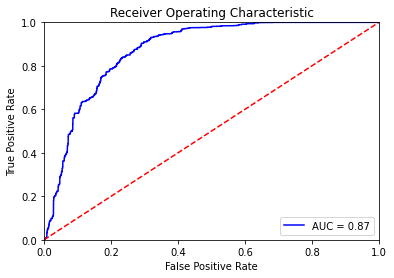

Val loss: 0.0032572008203715086,
METRICS -> Accuracy: 1.0, AUC: 0.8727756620514852
THRESHOLD -> pos mean dist 0.3623046278953552, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 030, 
Train loss: 0.002245744224637747


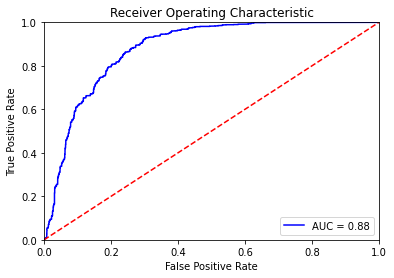

Val loss: 0.0032960206735879183,
METRICS -> Accuracy: 1.0, AUC: 0.8788892823424366
THRESHOLD -> pos mean dist 0.35841497778892517, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 031, 
Train loss: 0.002184923505410552


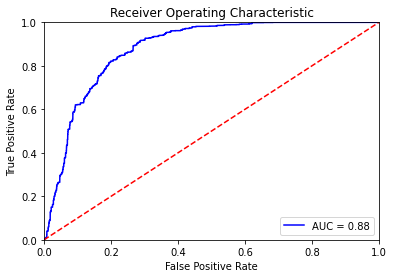

Val loss: 0.0030225624796003103,
METRICS -> Accuracy: 1.0, AUC: 0.8802504650599907
THRESHOLD -> pos mean dist 0.3624897003173828, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 032, 
Train loss: 0.0021719897631555796


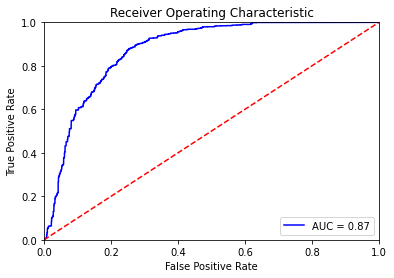

Val loss: 0.003467892063781619,
METRICS -> Accuracy: 1.0, AUC: 0.8747058236072323
THRESHOLD -> pos mean dist 0.3644227087497711, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 033, 
Train loss: 0.0021839875262230635


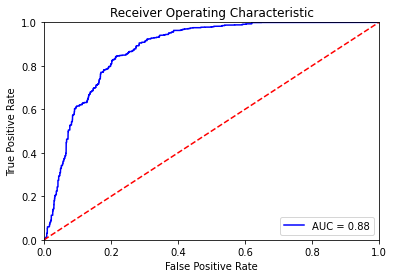

Val loss: 0.003357862588018179,
METRICS -> Accuracy: 1.0, AUC: 0.8775877050662614
THRESHOLD -> pos mean dist 0.3674353063106537, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 034, 
Train loss: 0.002146016340702772


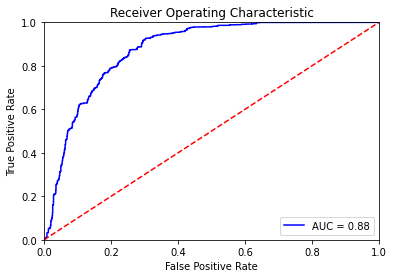

Val loss: 0.0033588057849556208,
METRICS -> Accuracy: 1.0, AUC: 0.8754109739812642
THRESHOLD -> pos mean dist 0.37814491987228394, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 035, 
Train loss: 0.002095929579809308


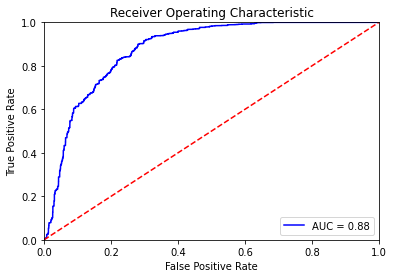

Val loss: 0.0033890530467033386,
METRICS -> Accuracy: 1.0, AUC: 0.8764072663563641
THRESHOLD -> pos mean dist 0.36771053075790405, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 036, 
Train loss: 0.0021242971997708082


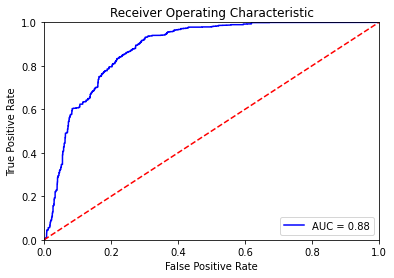

Val loss: 0.0031337586697191,
METRICS -> Accuracy: 1.0, AUC: 0.8801451488183807
THRESHOLD -> pos mean dist 0.37417730689048767, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 037, 
Train loss: 0.002086907858029008


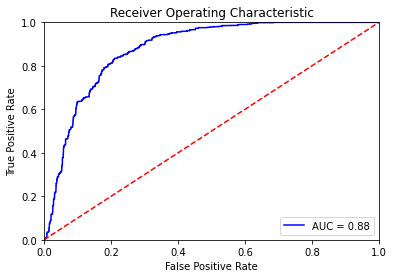

Val loss: 0.003228080691769719,
METRICS -> Accuracy: 1.0, AUC: 0.8780173220271237
THRESHOLD -> pos mean dist 0.37146294116973877, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 038, 
Train loss: 0.0019801792223006487


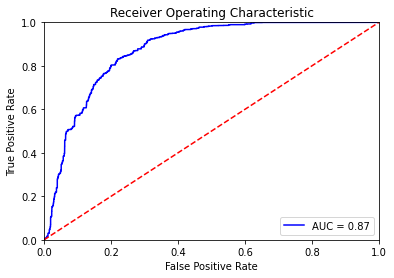

Val loss: 0.003184017026796937,
METRICS -> Accuracy: 1.0, AUC: 0.8743861284850909
THRESHOLD -> pos mean dist 0.3806847035884857, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 039, 
Train loss: 0.0020776439923793077


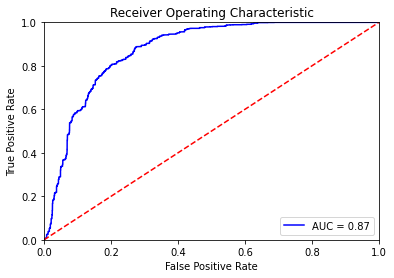

Val loss: 0.0032634215895086527,
METRICS -> Accuracy: 1.0, AUC: 0.8743586053731176
THRESHOLD -> pos mean dist 0.38375040888786316, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 040, 
Train loss: 0.002025123219937086


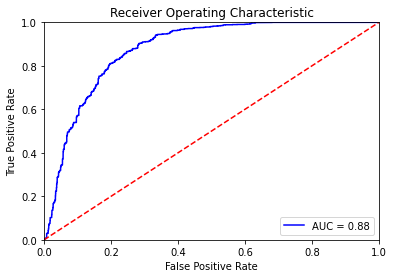

Val loss: 0.0034500963520258665,
METRICS -> Accuracy: 1.0, AUC: 0.8773129845232452
THRESHOLD -> pos mean dist 0.3755382299423218, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 041, 
Train loss: 0.0020480542443692684


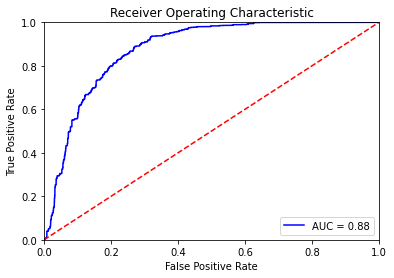

Val loss: 0.0030241720378398895,
METRICS -> Accuracy: 1.0, AUC: 0.8766544431742165
THRESHOLD -> pos mean dist 0.38473889231681824, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 042, 
Train loss: 0.0020724073983728886


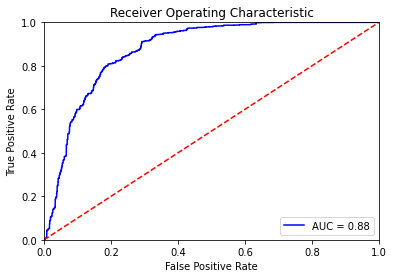

Val loss: 0.0033058705739676952,
METRICS -> Accuracy: 1.0, AUC: 0.8763536469954636
THRESHOLD -> pos mean dist 0.38825562596321106, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 043, 
Train loss: 0.001880914089269936


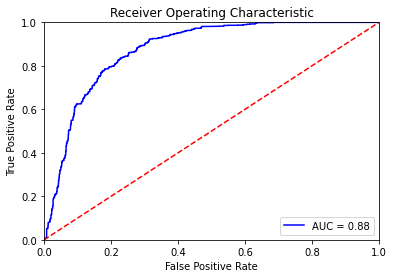

Val loss: 0.003186627058312297,
METRICS -> Accuracy: 1.0, AUC: 0.876349415587796
THRESHOLD -> pos mean dist 0.377035915851593, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 044, 
Train loss: 0.0019902565982192755


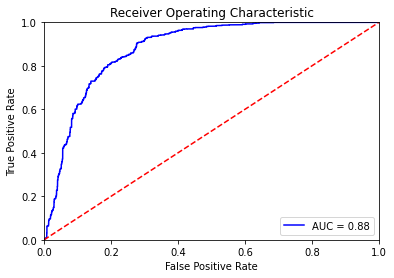

Val loss: 0.003061489900574088,
METRICS -> Accuracy: 1.0, AUC: 0.8803034549180738
THRESHOLD -> pos mean dist 0.3844406306743622, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 045, 
Train loss: 0.0019702885765582323


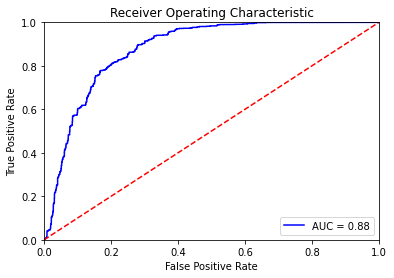

Val loss: 0.002991441870108247,
METRICS -> Accuracy: 1.0, AUC: 0.8779496561779091
THRESHOLD -> pos mean dist 0.39305007457733154, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 046, 
Train loss: 0.001959947170689702


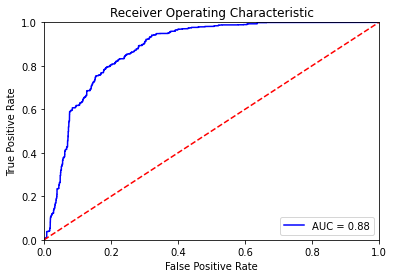

Val loss: 0.0032803723588585854,
METRICS -> Accuracy: 1.0, AUC: 0.8791602349243436
THRESHOLD -> pos mean dist 0.3912866711616516, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 047, 
Train loss: 0.0019856132566928864


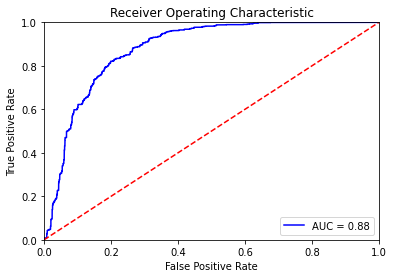

Val loss: 0.003048704471439123,
METRICS -> Accuracy: 1.0, AUC: 0.8788373736261735
THRESHOLD -> pos mean dist 0.3954405188560486, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 048, 
Train loss: 0.001927072647958994


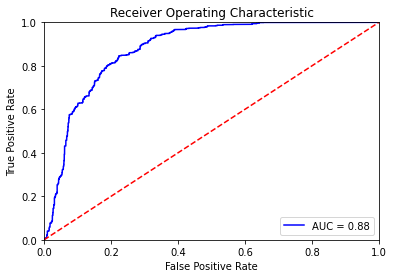

Val loss: 0.0031212898902595043,
METRICS -> Accuracy: 1.0, AUC: 0.8785352001160698
THRESHOLD -> pos mean dist 0.3906606435775757, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 049, 
Train loss: 0.001954477047547698


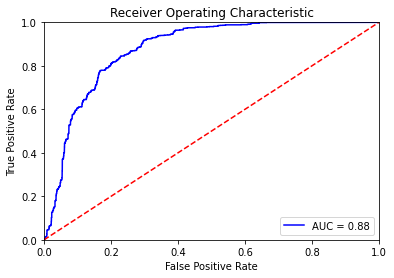

Val loss: 0.003034614259377122,
METRICS -> Accuracy: 1.0, AUC: 0.8771967434908876
THRESHOLD -> pos mean dist 0.4005793631076813, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 050, 
Train loss: 0.0018860719865188003


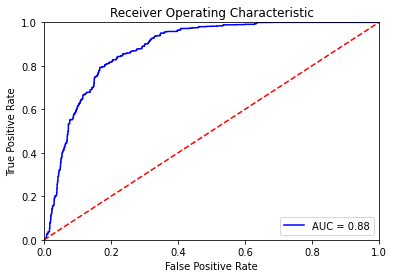

Val loss: 0.003185695968568325,
METRICS -> Accuracy: 1.0, AUC: 0.8809604756940915
THRESHOLD -> pos mean dist 0.39413249492645264, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 051, 
Train loss: 0.001903798896819353


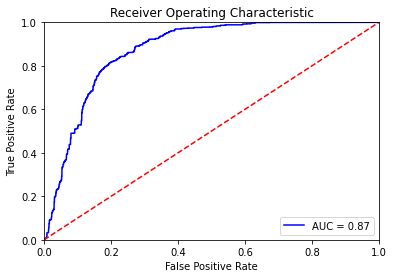

Val loss: 0.0032134002540260553,
METRICS -> Accuracy: 1.0, AUC: 0.8737221919837171
THRESHOLD -> pos mean dist 0.39072707295417786, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 052, 
Train loss: 0.0018790424801409245


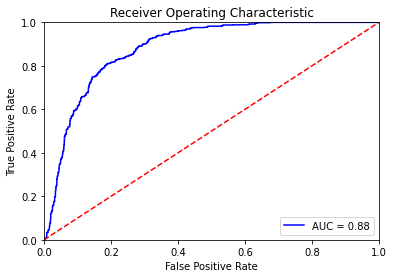

Val loss: 0.0031224736012518406,
METRICS -> Accuracy: 1.0, AUC: 0.8813558082664557
THRESHOLD -> pos mean dist 0.39616602659225464, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 053, 
Train loss: 0.0019868561066687107


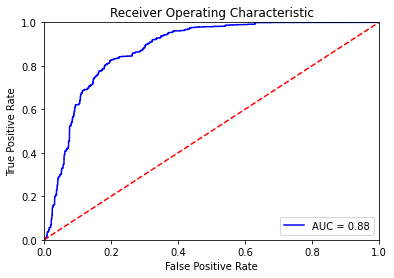

Val loss: 0.003125996794551611,
METRICS -> Accuracy: 1.0, AUC: 0.8780148538977736
THRESHOLD -> pos mean dist 0.3997882604598999, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 054, 
Train loss: 0.0018519869772717357


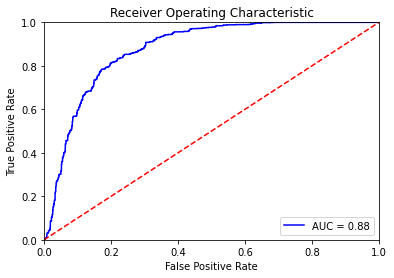

Val loss: 0.003139951964840293,
METRICS -> Accuracy: 1.0, AUC: 0.87620631862039
THRESHOLD -> pos mean dist 0.39828750491142273, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 055, 
Train loss: 0.0019282223656773567


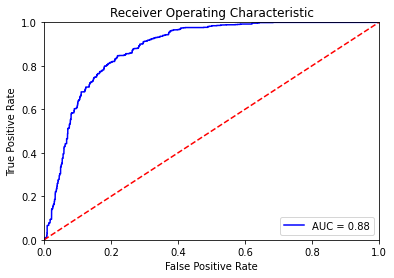

Val loss: 0.0030091924127191305,
METRICS -> Accuracy: 1.0, AUC: 0.8824282304068096
THRESHOLD -> pos mean dist 0.3907430171966553, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 056, 
Train loss: 0.0018829304026439786


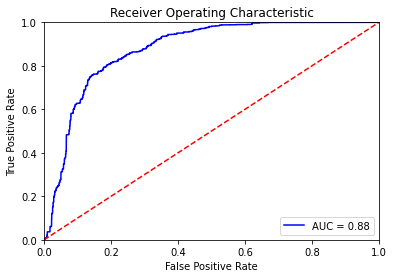

Val loss: 0.0034178777132183313,
METRICS -> Accuracy: 1.0, AUC: 0.8773513875472482
THRESHOLD -> pos mean dist 0.3985091745853424, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 057, 
Train loss: 0.0019003449706360698


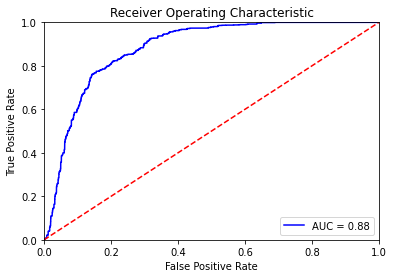

Val loss: 0.0030963916797190905,
METRICS -> Accuracy: 1.0, AUC: 0.8800804780857339
THRESHOLD -> pos mean dist 0.4028247594833374, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 058, 
Train loss: 0.001840265584178269


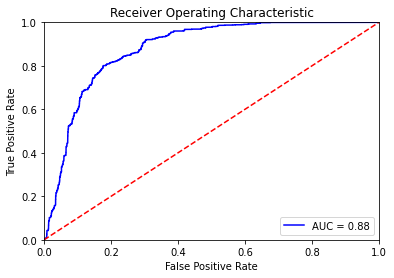

Val loss: 0.0031144744716584682,
METRICS -> Accuracy: 1.0, AUC: 0.878215539616083
THRESHOLD -> pos mean dist 0.3968018591403961, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 059, 
Train loss: 0.0018468303605914116


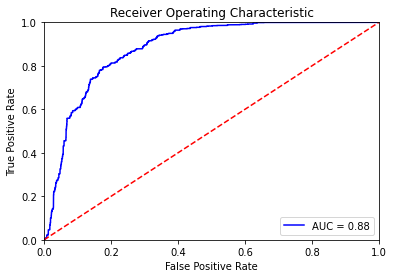

Val loss: 0.0028216317296028137,
METRICS -> Accuracy: 1.0, AUC: 0.8813869338336315
THRESHOLD -> pos mean dist 0.4118260145187378, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 060, 
Train loss: 0.0018806045409291983


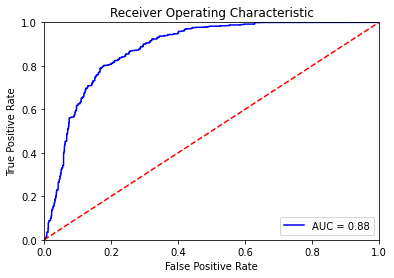

Val loss: 0.002947271801531315,
METRICS -> Accuracy: 1.0, AUC: 0.8792390607648096
THRESHOLD -> pos mean dist 0.4028465449810028, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 061, 
Train loss: 0.001837798161432147


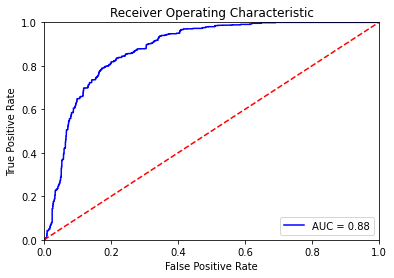

Val loss: 0.0031736609525978565,
METRICS -> Accuracy: 1.0, AUC: 0.8795849161768579
THRESHOLD -> pos mean dist 0.40630483627319336, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 062, 
Train loss: 0.001874490873888135


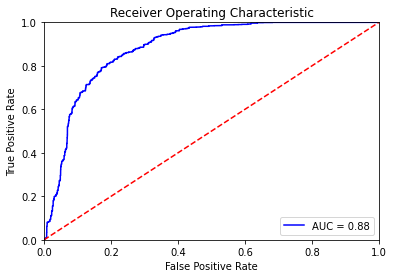

Val loss: 0.0029278879519551992,
METRICS -> Accuracy: 1.0, AUC: 0.8824688367907373
THRESHOLD -> pos mean dist 0.4046281576156616, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 063, 
Train loss: 0.0018556328723207116


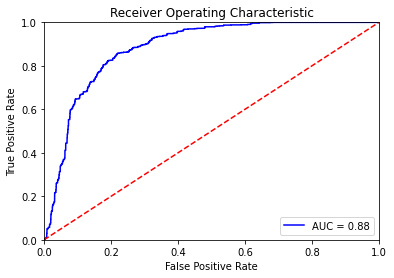

Val loss: 0.0030518060084432364,
METRICS -> Accuracy: 1.0, AUC: 0.8828751104142538
THRESHOLD -> pos mean dist 0.40395668148994446, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 064, 
Train loss: 0.0018925836775451899


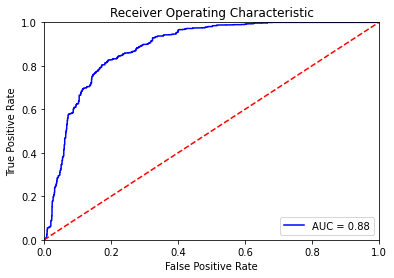

Val loss: 0.0028451750986278057,
METRICS -> Accuracy: 1.0, AUC: 0.8840497032333797
THRESHOLD -> pos mean dist 0.4137572944164276, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 065, 
Train loss: 0.0018462141742929816


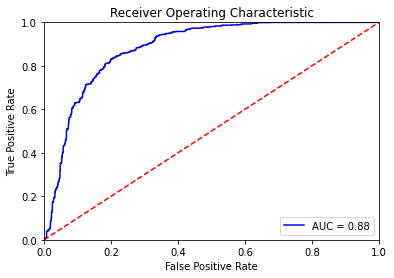

Val loss: 0.0030368524603545666,
METRICS -> Accuracy: 1.0, AUC: 0.8827622234281423
THRESHOLD -> pos mean dist 0.41189080476760864, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 066, 
Train loss: 0.0018557371804490685


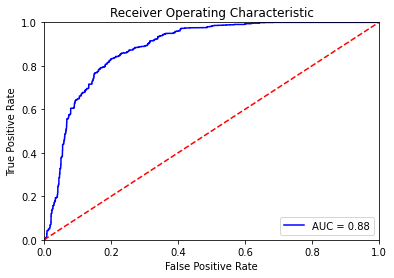

Val loss: 0.0031477860175073147,
METRICS -> Accuracy: 1.0, AUC: 0.8840779173375173
THRESHOLD -> pos mean dist 0.4062533974647522, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 067, 
Train loss: 0.0018196242162957788


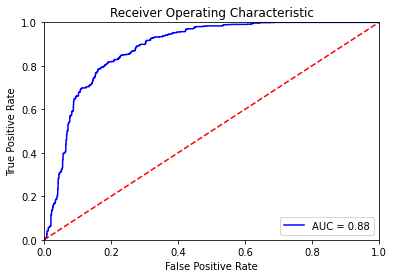

Val loss: 0.002959056757390499,
METRICS -> Accuracy: 1.0, AUC: 0.8825949576952012
THRESHOLD -> pos mean dist 0.40840381383895874, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 068, 
Train loss: 0.0017883722903206944


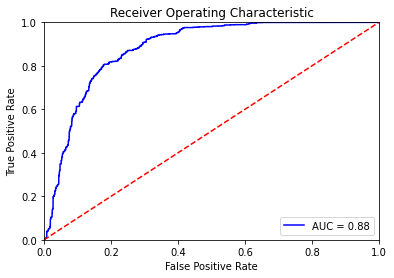

Val loss: 0.0031275541987270117,
METRICS -> Accuracy: 1.0, AUC: 0.8809480356837588
THRESHOLD -> pos mean dist 0.41567912697792053, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 069, 
Train loss: 0.0018319321097806096


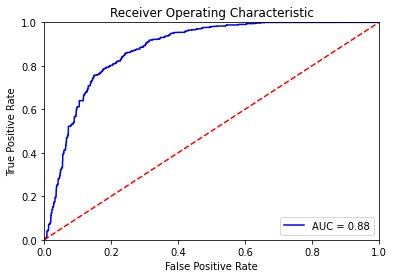

Val loss: 0.002960912650451064,
METRICS -> Accuracy: 1.0, AUC: 0.8773933134755492
THRESHOLD -> pos mean dist 0.41588351130485535, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 070, 
Train loss: 0.0017576804384589195


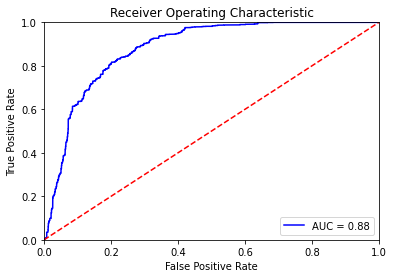

Val loss: 0.0030865606386214495,
METRICS -> Accuracy: 1.0, AUC: 0.8800915173497325
THRESHOLD -> pos mean dist 0.4135453999042511, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 071, 
Train loss: 0.001791095593944192


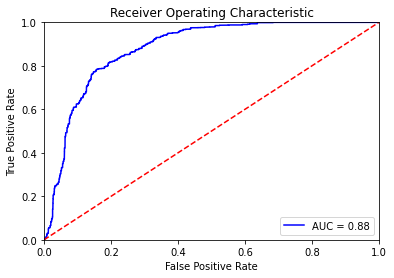

Val loss: 0.0028549060225486755,
METRICS -> Accuracy: 1.0, AUC: 0.881230804777023
THRESHOLD -> pos mean dist 0.4202100336551666, neg mean dist 0.5
{'mean_average_precision': 1.0}


Epoch: 072, 
Train loss: 0.0017204334726557136


In [ ]:
for epoch in range(num_epochs):
    # Training
    train_epoch(epoch, train_loader)

    # Validation
    test_epoch(epoch, val_loader, save_distances=True)

This is just to display some results, but it still doesn't work, we have to run it on sagemaker, so work in progress here...

In [ ]:
# We first define a function that loads (a subset of) the results and displays them
from IPython.display import Image, display, HTML
import random
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def display_results(results_file, subset_size = 10):

  lines = None
  with open(results_file, 'rb') as f:
    lines = pickle.load(f)
  
  photos = []
  with open("/content/drive/MyDrive/Colab Notebooks/photos.pkl", "rb") as f:
    photos = pickle.load(f)
  
  k=0
  for i in range(0, 5000, 800):
    print(f'anchor id :{lines[i][0]}')
    print(f'positive id:{lines[i][1]}')
    print(f'negative id:{lines[i][2]}')
    print(f'positive distance:{lines[i][3]}')
    print(f'negative distance:{lines[i][4]}')
    
    display(Image(photos[k], width=200, height=200), Image(photos[k], width=250, height=250))
    k+=1
    display(Image(photos[k], width=200, height=200))
    k+=1
    display(Image(photos[k], width=200, height=200))
    k+=1



display_results('1_results.pkl', 30)

ValueError: ignored

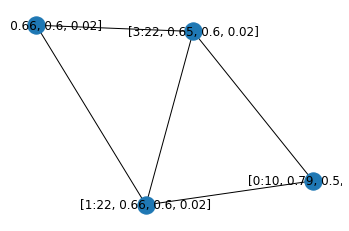

In [ ]:
g0, idx = data.get_by_photo_id('F_2020_08_23@11.02.16(225)_Converted_CROP_1_2095.jpg')
utils.display_graph(g0)
from IPython.display import display, Image
display(Image('F_2020_08_23@11.02.16(225)_Converted_CROP_1_2095.jpg'))